In [1]:
!pip install keras-tuner

     |████████████████████████████████| 133 kB 4.3 MB/s 


In [2]:
# Commented out IPython magic to ensure Python compatibility.
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import datetime as dt
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Dropout, Input
from sklearn.model_selection import train_test_split
import pprint as pp
import keras_tuner as kt
from tensorflow.keras.utils import plot_model
from sklearn.utils import shuffle
plt.rcParams["font.family"] = "Times New Roman"
plt.rc('font', size=12) 

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.


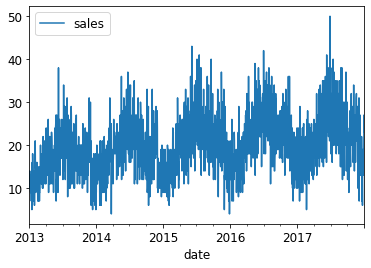

In [4]:
df = pd.read_excel("/content/drive/MyDrive/dataset.xlsx")
df.plot(x = 'date', y = 'sales')
plt.show()

In [5]:
raw_seq = df['sales']

In [6]:
train_seq = raw_seq[:1095]
val_seq = raw_seq[1095:1461].reset_index(drop=True)
test_seq = raw_seq[1461:].reset_index(drop=True)

In [7]:
print(train_seq.size, val_seq.size, test_seq.size)

1095 366 365


In [8]:
# univariate data preparation
# split a univariate sequence into samples
def split_sequence(sequence, n_steps):
  X, y = list(), list()
  for i in range(len(sequence)):
    # find the end of this pattern
    end_ix = i + n_steps
    # check if we are beyond the sequence
    if end_ix > len(sequence)-1:
      break
    # gather input and output parts of the pattern
    seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
    X.append(seq_x)
    y.append(seq_y)
  return np.array(X), np.array(y)

In [9]:
n_steps = 30
X_train, y_train = split_sequence(train_seq, n_steps)
X_train_shuffled, y_train_shuffled = shuffle(X_train, y_train, random_state=10)
X_test, y_test = split_sequence(test_seq, n_steps)
X_val, y_val = split_sequence(val_seq, n_steps)

In [ ]:
def mlp_model(hp):
  model = tf.keras.Sequential() 
  model.add(Input(shape=30))


  for i in range(hp.Int('num_layers', min_value=2, max_value=20, step=1)):
    hp_activation=hp.Choice('activation' + str(i), ['relu', 'tanh', 'relu'])
    model.add(Dense(units=hp.Int('units' + str(i), min_value=32, max_value=512, step=32), activation=hp_activation))
    model.add(Dropout(hp.Float('dropout' + str(i), 0, 0.5, step=0.1, default=0.0)))

  model.add(Dense(1, activation='linear'))

  model.compile(optimizer=tf.keras.optimizers.Adam(), loss='mse', metrics=[tf.keras.metrics.MeanAbsoluteError(), tf.keras.metrics.MeanSquaredError(), tf.keras.metrics.RootMeanSquaredError(), tf.keras.metrics.MeanAbsolutePercentageError()])

  return model

In [ ]:
tuner = kt.tuners.Hyperband(
    mlp_model,
    objective='val_mean_squared_error',
    max_epochs=30,
    hyperband_iterations=5,
    directory='dnn_exp',
    project_name='demand forecasting')

INFO:tensorflow:Reloading Oracle from existing project dnn_exp/demand forecasting/oracle.json
INFO:tensorflow:Reloading Tuner from dnn_exp/demand forecasting/tuner0.json


In [ ]:
tuner.search_space_summary()

Search space summary
Default search space size: 61
num_layers (Int)
{'default': None, 'conditions': [], 'min_value': 2, 'max_value': 20, 'step': 1, 'sampling': None}
activation0 (Choice)
{'default': 'relu', 'conditions': [], 'values': ['relu', 'tanh', 'relu'], 'ordered': False}
units0 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': None}
dropout0 (Float)
{'default': 0.0, 'conditions': [], 'min_value': 0.0, 'max_value': 0.5, 'step': 0.1, 'sampling': None}
activation1 (Choice)
{'default': 'relu', 'conditions': [], 'values': ['relu', 'tanh', 'relu'], 'ordered': False}
units1 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': None}
dropout1 (Float)
{'default': 0.0, 'conditions': [], 'min_value': 0.0, 'max_value': 0.5, 'step': 0.1, 'sampling': None}
activation2 (Choice)
{'default': 'relu', 'conditions': [], 'values': ['relu', 'tanh', 'relu'], 'ordered': False}
units2 (Int)
{'default': None

In [ ]:
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)

In [ ]:
tuner.search(X_train_shuffled, y_train_shuffled, epochs=50, validation_data=(X_val, y_val), callbacks=[stop_early])

INFO:tensorflow:Oracle triggered exit


In [ ]:
# Get the top 2 models.
models = tuner.get_best_models(num_models=2)
best_model = models[0]
# Build the model.
# Needed for `Sequential` without specified `input_shape`.
best_model.build(input_shape=(30, ))
best_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 416)               12896     
                                                                 
 dropout (Dropout)           (None, 416)               0         
                                                                 
 dense_1 (Dense)             (None, 416)               173472    
                                                                 
 dropout_1 (Dropout)         (None, 416)               0         
                                                                 
 dense_2 (Dense)             (None, 192)               80064     
                                                                 
 dropout_2 (Dropout)         (None, 192)               0         
                                                                 
 dense_3 (Dense)             (None, 1)                 1

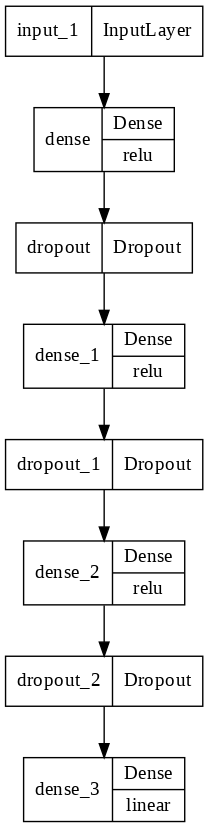

In [ ]:
plot_model(best_model, show_layer_activations=True, dpi=100)

In [ ]:
callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', min_delta=0, patience=100, verbose=0,
    mode='auto', baseline=None, restore_best_weights=True
)

In [ ]:
hist =  best_model.fit(X_train, y_train, batch_size=120, epochs=2000, verbose=2, validation_data=(X_val, y_val), callbacks=[callback])
score = best_model.evaluate(X_test, y_test, return_dict=True)
y_pred = best_model.predict(X_test)

Epoch 1/2000
9/9 - 0s - loss: 28.4118 - mean_absolute_error: 4.1368 - mean_squared_error: 28.4118 - root_mean_squared_error: 5.3303 - mean_absolute_percentage_error: 25.3250 - val_loss: 36.5196 - val_mean_absolute_error: 4.8465 - val_mean_squared_error: 36.5196 - val_root_mean_squared_error: 6.0431 - val_mean_absolute_percentage_error: 21.2264 - 147ms/epoch - 16ms/step
Epoch 2/2000
9/9 - 0s - loss: 27.5192 - mean_absolute_error: 4.1174 - mean_squared_error: 27.5192 - root_mean_squared_error: 5.2459 - mean_absolute_percentage_error: 25.2917 - val_loss: 52.4889 - val_mean_absolute_error: 5.9104 - val_mean_squared_error: 52.4889 - val_root_mean_squared_error: 7.2449 - val_mean_absolute_percentage_error: 24.7860 - 112ms/epoch - 12ms/step
Epoch 3/2000
9/9 - 0s - loss: 27.9841 - mean_absolute_error: 4.1796 - mean_squared_error: 27.9841 - root_mean_squared_error: 5.2900 - mean_absolute_percentage_error: 25.2801 - val_loss: 41.4161 - val_mean_absolute_error: 5.1704 - val_mean_squared_error: 41

In [ ]:
best_model.evaluate(X_train, y_train, return_dict=True)

34/34 [==============================] - 0s 3ms/step - loss: 21.3521 - mean_absolute_error: 3.6226 - mean_squared_error: 21.3521 - root_mean_squared_error: 4.6208 - mean_absolute_percentage_error: 21.6771


{'loss': 21.352094650268555,
 'mean_absolute_error': 3.622587203979492,
 'mean_absolute_percentage_error': 21.677112579345703,
 'mean_squared_error': 21.352094650268555,
 'root_mean_squared_error': 4.620832443237305}

In [ ]:
best_model.evaluate(X_val, y_val, return_dict=True)

11/11 [==============================] - 0s 3ms/step - loss: 26.3958 - mean_absolute_error: 4.0655 - mean_squared_error: 26.3958 - root_mean_squared_error: 5.1377 - mean_absolute_percentage_error: 19.6252


{'loss': 26.395803451538086,
 'mean_absolute_error': 4.065462112426758,
 'mean_absolute_percentage_error': 19.625165939331055,
 'mean_squared_error': 26.395803451538086,
 'root_mean_squared_error': 5.1376848220825195}

In [ ]:
score

{'loss': 28.744359970092773,
 'mean_absolute_error': 4.252379417419434,
 'mean_absolute_percentage_error': 20.384016036987305,
 'mean_squared_error': 28.744359970092773,
 'root_mean_squared_error': 5.361376762390137}

In [ ]:
print(hist.history.keys())

dict_keys(['loss', 'mean_absolute_error', 'mean_squared_error', 'root_mean_squared_error', 'mean_absolute_percentage_error', 'val_loss', 'val_mean_absolute_error', 'val_mean_squared_error', 'val_root_mean_squared_error', 'val_mean_absolute_percentage_error'])


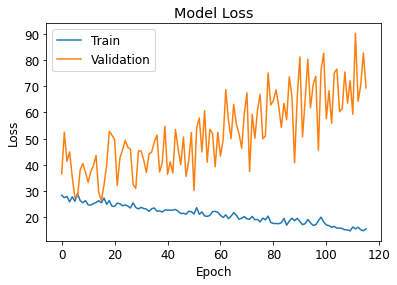

In [ ]:
# "Loss"
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.savefig("loss.png", dpi=300)
plt.show()

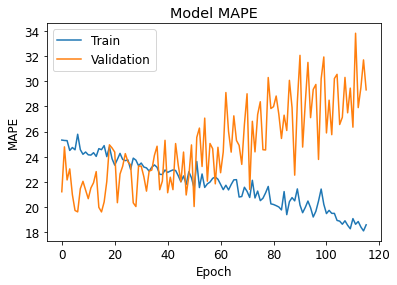

In [ ]:
# "Loss"
plt.plot(hist.history['mean_absolute_percentage_error'])
plt.plot(hist.history['val_mean_absolute_percentage_error'])
plt.title('Model MAPE')
plt.ylabel('MAPE')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.savefig("loss.png", dpi=300)
plt.show()

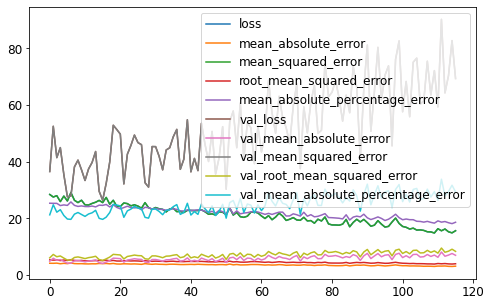

In [ ]:
pd.DataFrame(hist.history).plot(figsize=(8,5))
plt.show()

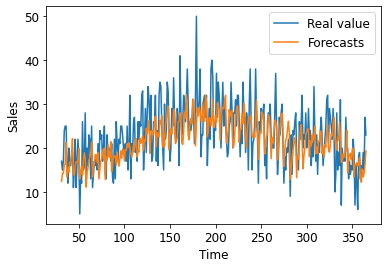

In [ ]:
dates = np.array(range(31, 366))
plt.plot(dates, y_test, label='Real value')
plt.plot(dates, y_pred, label='Forecasts')
plt.xlabel('Time', fontsize=12)
plt.ylabel('Sales', fontsize=12)
plt.legend()
plt.savefig("dnn_forecast.png", dpi=500)
plt.show()

In [ ]:
best_model.save('dnn.h5')

In [10]:
model = tf.keras.models.load_model('dnn.h5')

In [11]:
y_pred = model.predict(X_test)

In [12]:
from scipy import stats
stats.ttest_ind(y_pred, y_test)

Ttest_indResult(statistic=array([-2.3513312], dtype=float32), pvalue=array([0.01899596]))